# Master Daily DataSet for Corn Future Price

In [1]:
# Project 3      
#importing libraries 
import pandas as pd
import numpy as np
import seaborn as sns 
import datetime as dt
import plotly.express as px
import os
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
import hvplot.pandas
from pandas_datareader import data as wb
from statsmodels.tsa.arima_model import ARIMA
import investpy

## Data Prep - Pulling stock data for each US Dollar Index, Corn, Gas, Ethanol Futures from YahooFinance API

In [2]:
#Extract data from YahooFinance for 20 years
pd.core.common.is_list_like = pd.api.types.is_list_like
stocks = ['DX-Y.NYB', 'EH=F','ZC=F', 'NG=F']
# 'DXK18.NYB'
start = dt.datetime(2000,1,1)
end = dt.datetime.today()    
df = wb.DataReader(stocks, 'yahoo',start,end)["Adj Close"].sort_index()
# renaming the column names
df.columns.values[0] = "USD_Index"
df.columns.values[1] = "Ethanol_future"
df.columns.values[2] = "Corn_future"
df.columns.values[3] = "Natural_Gas_future"
df.tail()

Symbols,USD_Index,Ethanol_future,Corn_future,Natural_Gas_future
Date,,,,
2020-11-17,92.419998,1.42,420.25,2.692
2020-11-18,92.320000,1.42,425.75,2.712
2020-11-19,92.290001,1.39,422.50,2.592
2020-11-20,92.400002,1.39,423.25,2.650
2020-11-23,92.517998,1.41,433.50,2.714


In [3]:
# Basic data checks
df.count(), df.isnull().sum(), df.shape

(Symbols
 USD_Index             5260
 Ethanol_future        3890
 Corn_future           5057
 Natural_Gas_future    5082
 dtype: int64,
 Symbols
 USD_Index               31
 Ethanol_future        1401
 Corn_future            234
 Natural_Gas_future     209
 dtype: int64,
 (5291, 4))

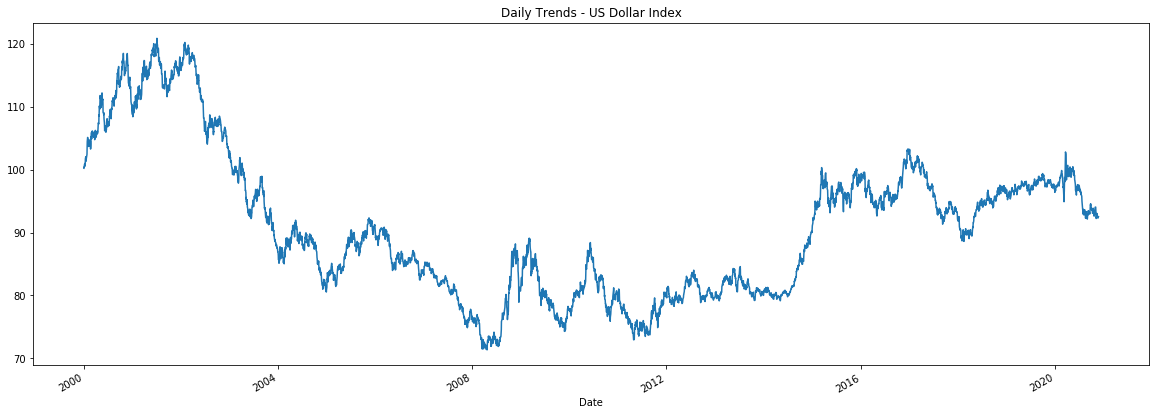

In [4]:
# Plotting and saving the trends.
df["USD_Index"].dropna().plot(title='Daily Trends - US Dollar Index', figsize=(20,7))
plt.savefig("../Images/Trends_US_Index.png")

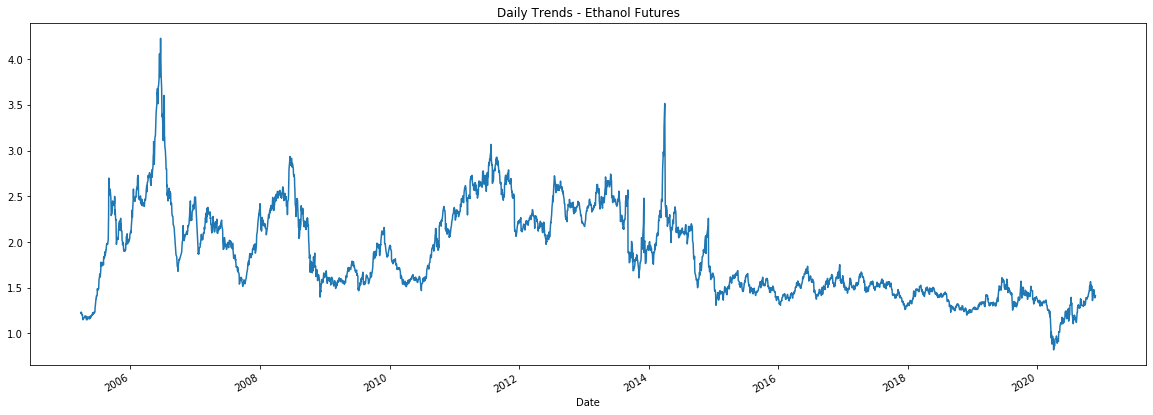

In [5]:
# Plotting and saving the trends.
df["Ethanol_future"].dropna().plot(title='Daily Trends - Ethanol Futures', figsize=(20,7))
plt.savefig("../Images/Trends_Ethanol_Futures.png")

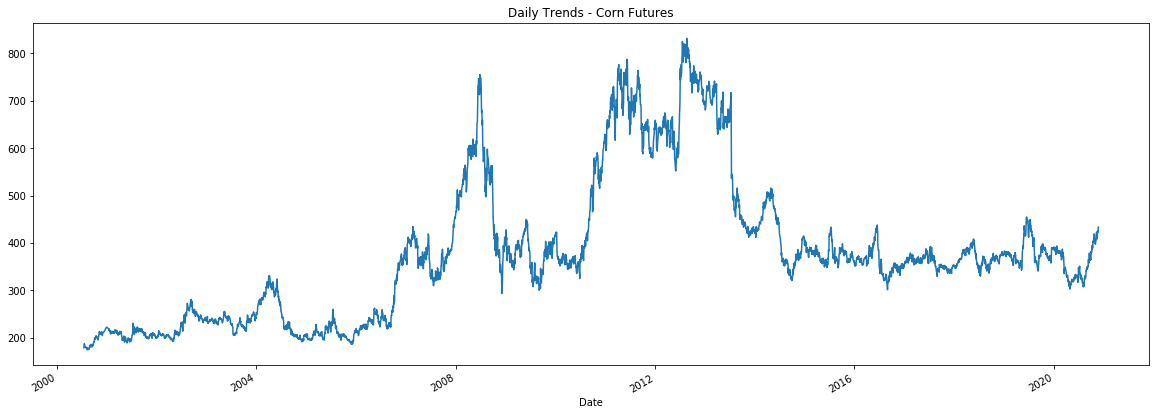

In [6]:
# Plotting and saving the trends.
df["Corn_future"].dropna().plot(title='Daily Trends - Corn Futures', figsize=(20,7))
plt.savefig("../Images/Trends_Corn_Futures.png")

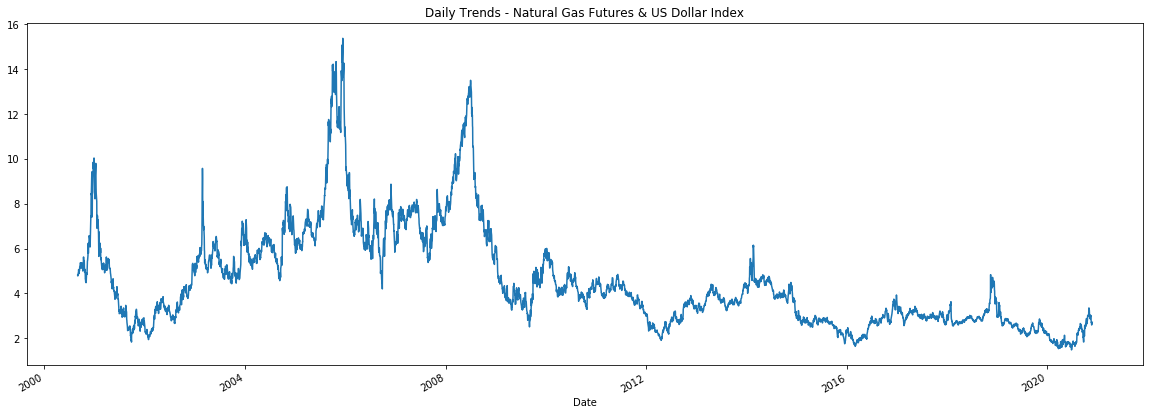

In [7]:
# Plotting and saving the trends.
df["Natural_Gas_future"].dropna().plot(title='Daily Trends - Natural Gas Futures & US Dollar Index', figsize=(20,7))
plt.savefig("../Images/Trends_Natural_Gas_Futures.png")

In [8]:
# Read in corn actual price and sort by date
corn_act_prices = pd.read_csv(Path("../Resources/corn-prices-historical-chart-data.csv"), index_col="date", infer_datetime_format=True, parse_dates=True).sort_index()
# Drop corn actual price data prior to 2000
corn_act_prices = corn_act_prices.loc['2000-1-1':]
# Rename the columns
corn_act_prices.columns.values[0] = "Corn_Price"
corn_act_prices.index.names = ['Date']
# Drop nulls from the DataFrame
corn_act_prices.dropna(inplace=True)
corn_act_prices.tail()

,Corn_Price
Date,
2020-11-16,4.1625
2020-11-17,4.2025
2020-11-18,4.2575
2020-11-19,4.2250
2020-11-20,4.2325


In [9]:
# Basic data check in terms of rows and colummns
corn_act_prices.shape

(5264, 1)

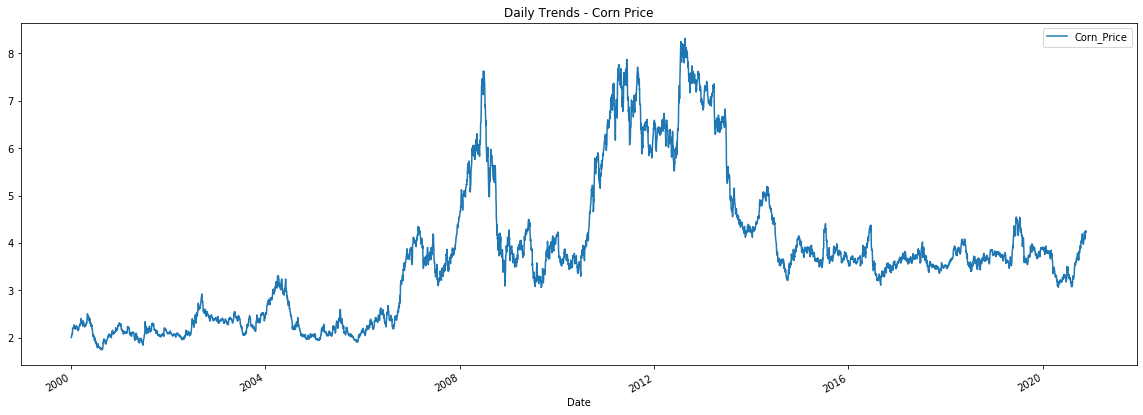

In [10]:
# Plotting and saving the Corn price trends.
corn_act_prices.dropna().plot(title='Daily Trends - Corn Price', figsize=(20,7))
plt.savefig("../Images/Trends_Corn_Price.png")

In [11]:
# Read in corn actual price and sort by date
weather_data = pd.read_csv(Path("../Resources/corn_belt_weather.csv"), index_col="date", infer_datetime_format=True, parse_dates=True).sort_index()
weather_data.index.names = ['Date']
weather_data.head(2)

,PRCP_Illinois,TMAX_Illinois,TMIN_Illinois,PRCP_Indiana,TMAX_Indiana,TMIN_Indiana,PRCP_Nebraska,TMAX_Nebraska,TMIN_Nebraska,PRCP_Ohio,TMAX_Ohio,TMIN_Ohio,PRCP_Iowa,TMAX_Iowa,TMIN_Iowa
Date,,,,,,,,,,,,,,,
2000-01-01,0.000000,7.78,-2.34,0.00,10.6375,-3.4125,0.0000,9.757143,-5.785714,0.0,9.1000,-5.7000,0.0,6.100000,-2.950000
2000-01-02,0.166667,12.44,0.88,0.31,15.2125,1.3250,0.0375,6.312500,-7.425000,0.0,13.6125,-0.2875,0.4,6.383333,0.183333


In [12]:
# Basic data checks to see count of rows for each column and nulls
weather_data.count(), weather_data.isnull().sum()

(PRCP_Illinois    7305
 TMAX_Illinois    7305
 TMIN_Illinois    7305
 PRCP_Indiana     7305
 TMAX_Indiana     7305
 TMIN_Indiana     7305
 PRCP_Nebraska    7305
 TMAX_Nebraska    7305
 TMIN_Nebraska    7305
 PRCP_Ohio        7305
 TMAX_Ohio        7305
 TMIN_Ohio        7305
 PRCP_Iowa        7305
 TMAX_Iowa        7305
 TMIN_Iowa        7305
 dtype: int64,
 PRCP_Illinois    0
 TMAX_Illinois    0
 TMIN_Illinois    0
 PRCP_Indiana     0
 TMAX_Indiana     0
 TMIN_Indiana     0
 PRCP_Nebraska    0
 TMAX_Nebraska    0
 TMIN_Nebraska    0
 PRCP_Ohio        0
 TMAX_Ohio        0
 TMIN_Ohio        0
 PRCP_Iowa        0
 TMAX_Iowa        0
 TMIN_Iowa        0
 dtype: int64)

In [13]:
# Calculating Averages
weather_data["avg_prcp"] = (weather_data["PRCP_Illinois"] + weather_data["PRCP_Indiana"] + weather_data["PRCP_Iowa"] +weather_data["PRCP_Nebraska"]+ weather_data["PRCP_Ohio"])/5
weather_data["avg_max"] = (weather_data["TMAX_Illinois"] + weather_data["TMAX_Indiana"] + weather_data["TMAX_Iowa"] +weather_data["TMAX_Nebraska"]+ weather_data["TMAX_Ohio"])/5
weather_data["avg_min"] = (weather_data["TMIN_Illinois"] + weather_data["TMIN_Indiana"] + weather_data["TMIN_Iowa"] +weather_data["TMIN_Nebraska"]+ weather_data["TMIN_Ohio"])/5
#Keeping only the averages precipitation, maximum and minimum temperatures of the 5 states in the USA
weather_data = weather_data[["avg_prcp", "avg_max", "avg_min"]]
weather_data.head()

,avg_prcp,avg_max,avg_min
Date,,,
2000-01-01,0.000000,8.674929,-4.037643
2000-01-02,0.182833,10.792167,-1.064833
2000-01-03,6.071857,10.758000,0.189167
2000-01-04,12.531881,5.417500,-6.070000
2000-01-05,0.314429,1.016667,-9.583786


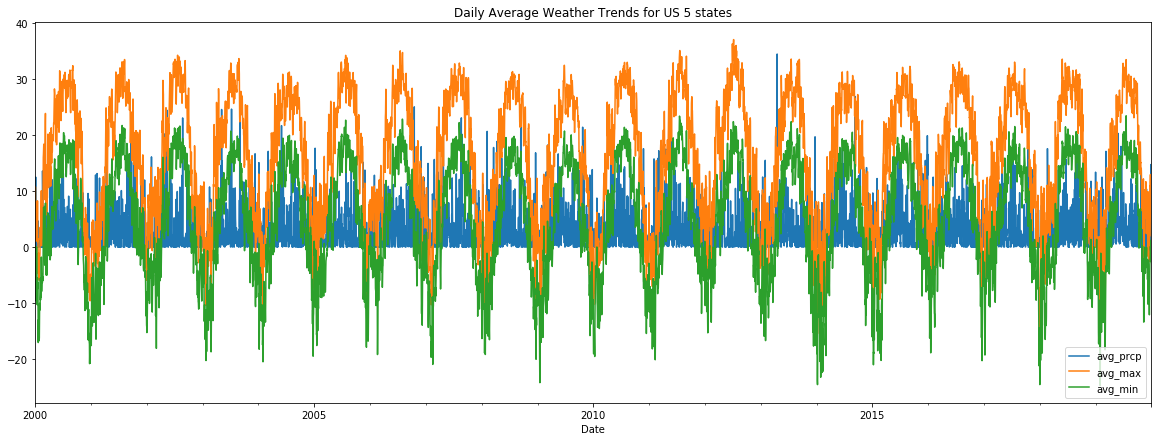

In [14]:
# Plotting and saving the Corn price trends.
weather_data.plot(title='Daily Average Weather Trends for US 5 states', figsize=(20,7))
plt.savefig("../Images/Trends_weather.png")

In [15]:
# Merge corn price, yahoo data and weather data
combined_portfolios_df = pd.concat(
    [corn_act_prices, df, weather_data], axis="columns", join="inner"
)
combined_portfolios_df
combined_portfolios_df.head()

,Corn_Price,USD_Index,Ethanol_future,Corn_future,Natural_Gas_future,avg_prcp,avg_max,avg_min
Date,,,,,,,,
2000-01-03,2.0075,100.220001,NaN,NaN,NaN,6.071857,10.758000,0.189167
2000-01-04,2.0300,100.410004,NaN,NaN,NaN,12.531881,5.417500,-6.070000
2000-01-05,2.0300,100.379997,NaN,NaN,NaN,0.314429,1.016667,-9.583786
2000-01-06,2.0375,100.650002,NaN,NaN,NaN,0.164167,1.607333,-7.532000
2000-01-07,2.0700,100.800003,NaN,NaN,NaN,0.031429,4.856333,-7.030095


In [16]:
# Check Data Types, count of each column,checking nulls and share of the DataFrame
combined_portfolios_df.dtypes, combined_portfolios_df.count(), combined_portfolios_df.isnull().sum(), combined_portfolios_df.shape

(Corn_Price            float64
 USD_Index             float64
 Ethanol_future        float64
 Corn_future           float64
 Natural_Gas_future    float64
 avg_prcp              float64
 avg_max               float64
 avg_min               float64
 dtype: object,
 Corn_Price            5001
 USD_Index             4999
 Ethanol_future        3661
 Corn_future           4824
 Natural_Gas_future    4822
 avg_prcp              5001
 avg_max               5001
 avg_min               5001
 dtype: int64,
 Corn_Price               0
 USD_Index                2
 Ethanol_future        1340
 Corn_future            177
 Natural_Gas_future     179
 avg_prcp                 0
 avg_max                  0
 avg_min                  0
 dtype: int64,
 (5001, 8))

In [17]:
# Drop nulls from combined DataFrame
combined_portfolios_df.dropna(inplace=True)

In [18]:
# Final data checks
combined_portfolios_df.isnull().sum(), combined_portfolios_df.shape, combined_portfolios_df.describe()

(Corn_Price            0
 USD_Index             0
 Ethanol_future        0
 Corn_future           0
 Natural_Gas_future    0
 avg_prcp              0
 avg_max               0
 avg_min               0
 dtype: int64,
 (3657, 8),
         Corn_Price    USD_Index  Ethanol_future  Corn_future  \
 count  3657.000000  3657.000000     3657.000000  3657.000000   
 mean      4.306932    86.383683        1.903205   429.838187   
 std       1.423506     8.064636        0.481076   144.207434   
 min       1.907500    71.330002        1.150000   186.250000   
 25%       3.565000    80.010002        1.508000   354.000000   
 50%       3.800000    84.610001        1.780000   378.250000   
 75%       4.960000    94.620003        2.273000   497.000000   
 max       8.312500   103.290001        4.230000   831.250000   
 
        Natural_Gas_future     avg_prcp      avg_max      avg_min  
 count         3657.000000  3657.000000  3657.000000  3657.000000  
 mean             4.570518     2.764998    16.8097

In [19]:
# Save the master daily data without NA values into a csv file
combined_portfolios_df.to_csv("../Resources/combined_portfolios_df.csv")

In [20]:
#Construct a correlation table
correlation_table = combined_portfolios_df.corr()
correlation_table

,Corn_Price,USD_Index,Ethanol_future,Corn_future,Natural_Gas_future,avg_prcp,avg_max,avg_min
Corn_Price,1.000000,-0.532916,0.522686,0.997814,-0.173445,0.006128,-0.019731,-0.036159
USD_Index,-0.532916,1.000000,-0.655777,-0.530475,-0.406367,-0.004439,-0.015594,-0.001572
Ethanol_future,0.522686,-0.655777,1.000000,0.524249,0.399690,0.003007,0.079729,0.064400
Corn_future,0.997814,-0.530475,0.524249,1.000000,-0.177565,0.007355,-0.012443,-0.028688
Natural_Gas_future,-0.173445,-0.406367,0.399690,-0.177565,1.000000,0.007902,-0.022014,-0.022379
avg_prcp,0.006128,-0.004439,0.003007,0.007355,0.007902,1.000000,0.183335,0.257701
avg_max,-0.019731,-0.015594,0.079729,-0.012443,-0.022014,0.183335,1.000000,0.976319
avg_min,-0.036159,-0.001572,0.064400,-0.028688,-0.022379,0.257701,0.976319,1.000000


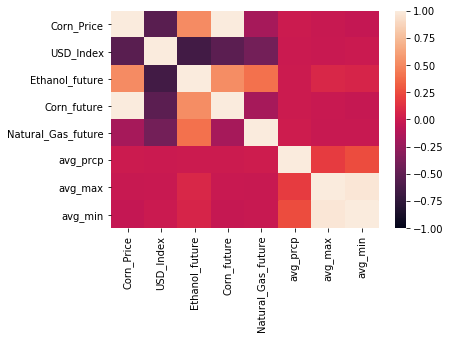

In [21]:
#correlation matrix using a heatmap
sns.heatmap(correlation_table, vmin=-1, vmax=1)

In [22]:
combined_portfolios_df.head()

,Corn_Price,USD_Index,Ethanol_future,Corn_future,Natural_Gas_future,avg_prcp,avg_max,avg_min
Date,,,,,,,,
2005-03-28,2.1275,84.620003,1.230,212.75,6.999,4.255071,14.112571,1.306000
2005-03-29,2.1300,84.320000,1.225,213.00,7.323,2.576857,18.172214,3.058357
2005-03-30,2.1250,84.290001,1.215,212.50,7.460,1.493571,20.439500,5.811500
2005-03-31,2.1300,84.059998,1.230,213.00,7.653,3.674524,19.387071,4.848714
2005-04-01,2.1275,84.430000,1.215,212.75,7.749,1.049500,15.029214,1.856000


## Extra Variables to be explored later - China Imports and Inflation Rates

In [23]:
# Read in China Yearly Imports and sort by year
china_imports_df = pd.read_csv(Path("../Resources/china_imports.csv")).sort_index()
# delete last row
china_imports_df = china_imports_df[:-1]
china_imports_df.head(2)

,Year,Imports,Unit of Measure
0,2000,89.0,(1000 MT)
1,2001,39.0,(1000 MT)


In [24]:
# Creating Monthly imports from Yearly Numbers
china_imports_df["Monthly_Imports_MT"] = round(((china_imports_df["Imports"] * 1000)/12),2)
# Add Monthly columns and fill it with daily imports numbers 
china_imports_df.insert(2,'DEC', china_imports_df["Monthly_Imports_MT"]) 
china_imports_df.insert(2,'NOV', china_imports_df["Monthly_Imports_MT"])
china_imports_df.insert(2,'OCT', china_imports_df["Monthly_Imports_MT"])
china_imports_df.insert(2,'SEP', china_imports_df["Monthly_Imports_MT"])
china_imports_df.insert(2,'AUG', china_imports_df["Monthly_Imports_MT"])
china_imports_df.insert(2,'JUL', china_imports_df["Monthly_Imports_MT"])
china_imports_df.insert(2,'JUN', china_imports_df["Monthly_Imports_MT"])
china_imports_df.insert(2,'MAY', china_imports_df["Monthly_Imports_MT"])
china_imports_df.insert(2,'APR', china_imports_df["Monthly_Imports_MT"])
china_imports_df.insert(2,'MAR', china_imports_df["Monthly_Imports_MT"])
china_imports_df.insert(2,'FEB', china_imports_df["Monthly_Imports_MT"])
china_imports_df.insert(2,'JAN',china_imports_df["Monthly_Imports_MT"]) 
china_imports_df =china_imports_df.drop(['Imports', 'Unit of Measure', 'Monthly_Imports_MT'], axis=1)
china_imports_df.head()

,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,2000,7416.67,7416.67,7416.67,7416.67,7416.67,7416.67,7416.67,7416.67,7416.67,7416.67,7416.67,7416.67
1,2001,3250.00,3250.00,3250.00,3250.00,3250.00,3250.00,3250.00,3250.00,3250.00,3250.00,3250.00,3250.00
2,2002,2416.67,2416.67,2416.67,2416.67,2416.67,2416.67,2416.67,2416.67,2416.67,2416.67,2416.67,2416.67
3,2003,166.67,166.67,166.67,166.67,166.67,166.67,166.67,166.67,166.67,166.67,166.67,166.67
4,2004,166.67,166.67,166.67,166.67,166.67,166.67,166.67,166.67,166.67,166.67,166.67,166.67


In [25]:
china_imports_df.set_index('Year', inplace=True)
# Converting columns into rows
result_df = [] 
for i,row in china_imports_df.iterrows():
    df_t = pd.DataFrame(row)
    df_t.reset_index(inplace=True)
    df_t['index'] = str(i) + "-" + df_t['index']
    df_t.set_index('index', inplace=True)
    df_t.columns = ['China Import']
    
    result_df.append(df_t)
china_imports_df = pd.concat(result_df)
china_imports_df.shape, china_imports_df.tail()

((252, 1),
           China Import
 index                 
 2020-AUG     583333.33
 2020-SEP     583333.33
 2020-OCT     583333.33
 2020-NOV     583333.33
 2020-DEC     583333.33)

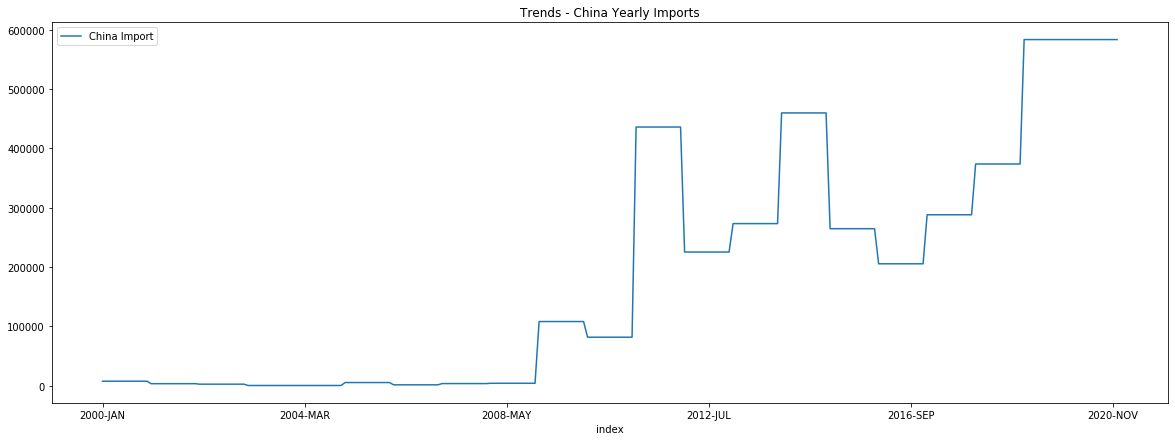

In [26]:
# Plotting the China Yearly Imports trends.
china_imports_df.dropna().plot(title='Trends - China Yearly Imports', figsize=(20,7))
plt.savefig("../Images/Trends_China_Imports.png")

In [27]:
# Read in China Monthly inflation rates and sort by month
cn_inflation_rate_df = pd.read_csv(Path("../Resources/china_inflation_rate.csv")).sort_index()
#Renaming the Year column
cn_inflation_rate_df.columns.values[0] = "Year"
cn_inflation_rate_df.tail(2)

,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,AVE
19,2019,1.71,1.50,2.28,2.57,2.76,2.67,2.76,2.83,3.00,3.75,4.51,4.41,2.9
20,2020,5.42,5.18,4.27,3.25,2.41,2.51,1.76,2.39,1.73,NaN,NaN,NaN,3.2


In [28]:
cn_inflation_rate_df.set_index('Year', inplace=True)
# Converting columns into rows
result_df = [] 
for i,row in cn_inflation_rate_df.iterrows():
    df_t = pd.DataFrame(row)
    df_t.reset_index(inplace=True)
    df_t['index'] = str(i) + "-" + df_t['index']
    df_t.set_index('index', inplace=True)
    df_t.columns = ['China Inflation Rate']
    
    result_df.append(df_t)
cn_inflation_rate_df = pd.concat(result_df)
cn_inflation_rate_df.shape, cn_inflation_rate_df.tail()

((273, 1),
           China Inflation Rate
 index                         
 2020-SEP                  1.73
 2020-OCT                   NaN
 2020-NOV                   NaN
 2020-DEC                   NaN
 2020-AVE                  3.20)

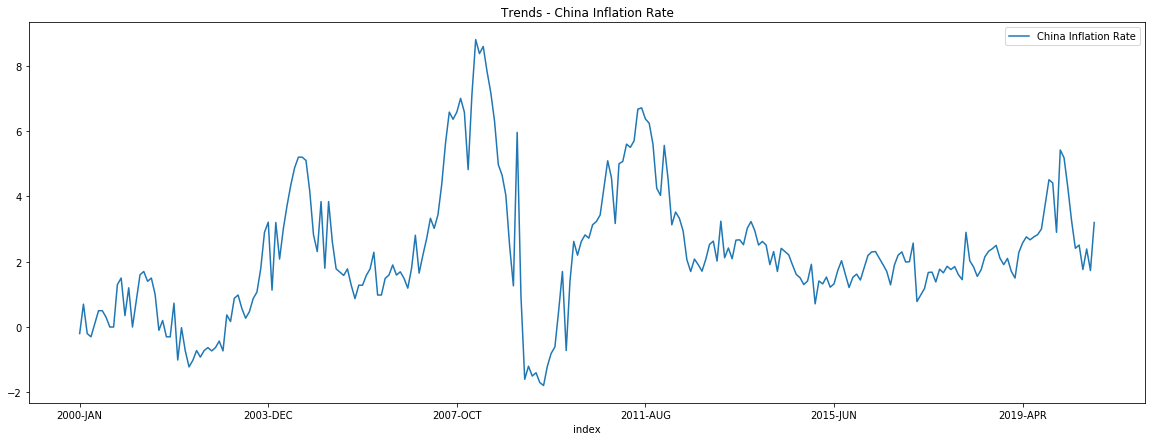

In [29]:
# Plotting the China Yearly Imports trends.
cn_inflation_rate_df.dropna().plot(title='Trends - China Inflation Rate', figsize=(20,7))
plt.savefig("../Images/Trends_China_Inflation.png")

In [30]:
# Read in USA Monthly inflation rates and sort by month
us_inflation_rate_df = pd.read_csv(Path("../Resources/us_inflation_rate.csv")).sort_index()
#Renaming the Year column
us_inflation_rate_df.columns.values[0] = "Year"
#Dropping Average
us_inflation_rate_df = us_inflation_rate_df.drop(columns=["AVE"])
us_inflation_rate_df.tail()

,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
102,2016,1.4,1.0,0.9,1.1,1.0,1.0,0.8,1.1,1.5,1.6,1.7,2.1
103,2017,2.5,2.7,2.4,2.2,1.9,1.6,1.7,1.9,2.2,2.0,2.2,2.1
104,2018,2.1,2.2,2.4,2.5,2.8,2.9,2.9,2.7,2.3,2.5,2.2,1.9
105,2019,1.6,1.5,1.9,2.0,1.8,1.6,1.8,1.7,1.7,1.8,2.1,2.3
106,2020,2.5,2.3,1.5,0.3,0.1,0.6,1.0,1.3,1.4,1.2,NaN,NaN


In [31]:
us_inflation_rate_df.set_index('Year', inplace=True)
# Converting columns into rows
result_df = [] 
for i,row in us_inflation_rate_df.iterrows():
    df_t = pd.DataFrame(row)
    df_t.reset_index(inplace=True)
    df_t['index'] = str(i) + "-" + df_t['index']
    df_t.set_index('index', inplace=True)
    df_t.columns = ['USA Inflation Rate']
    
    result_df.append(df_t)
us_inflation_rate_df = pd.concat(result_df)
us_inflation_rate_df.shape, us_inflation_rate_df.tail()

((1284, 1),
           USA Inflation Rate
 index                       
 2020-AUG                 1.3
 2020-SEP                 1.4
 2020-OCT                 1.2
 2020-NOV                 NaN
 2020-DEC                 NaN)

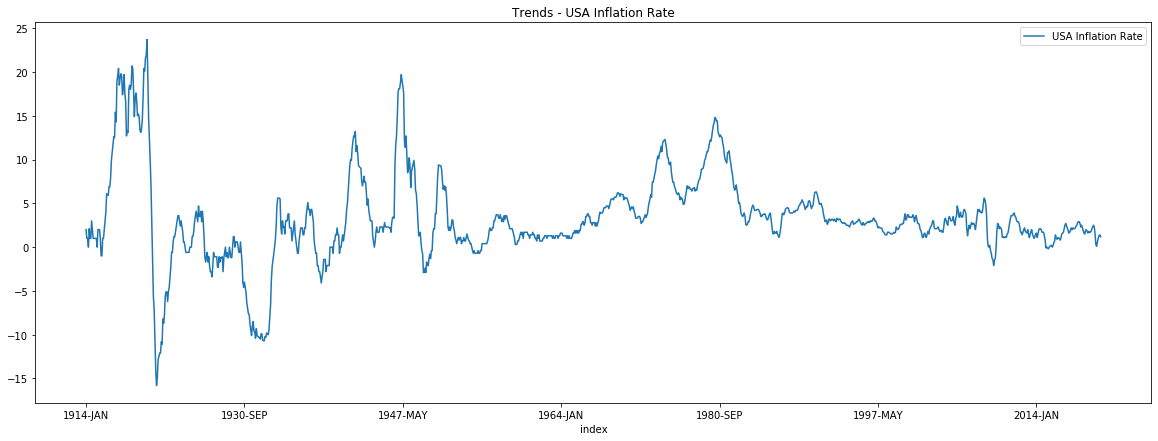

In [32]:
# Plotting the USA Yearly Imports trends.
us_inflation_rate_df.dropna().plot(title='Trends - USA Inflation Rate', figsize=(20,7))
plt.savefig("../Images/Trends_USA_Inflation.png")

In [33]:
# Read in final big data
## Combine 
monthly_import_inf_df = pd.concat(
    [china_imports_df,cn_inflation_rate_df, us_inflation_rate_df], axis="columns", join="inner"
)
monthly_import_inf_df
# Dropping Null values
monthly_import_inf_df.dropna(inplace=True)
monthly_import_inf_df.head(), monthly_import_inf_df.shape

(          China Import  China Inflation Rate  USA Inflation Rate
 index                                                           
 2000-JAN       7416.67                  -0.2                 2.7
 2000-FEB       7416.67                   0.7                 3.2
 2000-MAR       7416.67                  -0.2                 3.8
 2000-APR       7416.67                  -0.3                 3.1
 2000-MAY       7416.67                   0.1                 3.2,
 (249, 3))

In [34]:
# Save the monthly import and inflation data without NA values into a csv file
monthly_import_inf_df.to_csv("../Resources/monthly_import_inf_df.csv")